<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Structure_Relaxation_Phonons_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examples how to use ALIGNN-FF (https://doi.org/10.1039/D2DD00096B) Pre-trained model.

An example of training ALIGNN-FF from scratch for 307K dataset is given [here](https://github.com/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Train_ALIGNNFF_JARVIS_DFT_DB_307k.ipynb)

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

Installation with conda

In [2]:
# %%time

# !conda install dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda phonopy -c pytorch -c nvidia --quiet

In [3]:
# !pip uninstall alignn -y
# !pip install -q -U git+https://github.com/usnistgov/alignn.git@develop

In [4]:
%%time
import os
# !pip install -q alignn
# !pip uninstall dgl -y
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
   !git clone https://github.com/atomgptlab/alignn.git
os.chdir("alignn")

!git checkout develop
!pip install -q --no-cache-dir dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
!pip install -e .
# !uv pip install -q -e .
os.chdir('/content')

Cloning into 'alignn'...
remote: Enumerating objects: 5317, done.
remote: Counting objects: 100% (519/519), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 5317 (delta 509), reused 489 (delta 489), pack-reused 4798 (from 1)
Receiving objects: 100% (5317/5317), 155.11 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (3241/3241), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 195.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 146.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 141.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 145.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 242.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.

CPU times: user 3.05 s, sys: 302 ms, total: 3.35 s
Wall time: 3min 24s


Import necessary libraries

In [14]:
!pip install -q "phonopy==2.10.0"
#Might have to restart session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import (
    phonons,
    AlignnAtomwiseCalculator,
    default_path,
)
from jarvis.db.figshare import get_jid_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, get_supercell_dims
from tqdm import tqdm
from ase.constraints import ExpCellFilter
from sklearn.metrics import mean_absolute_error
import time
from jarvis.core.atoms import ase_to_atoms
from ase.optimize.fire import FIRE
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution



A few examples of metals, semiconductors and insulators

In [2]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]


In [3]:
def general_relaxer(atoms="", calculator="", fmax=0.05, steps=150):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms)

    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=steps)
    return ase_to_atoms(ase_atoms.atoms)


/content/alignn/alignn/ff/calculators.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


dir_path /content/alignn/alignn/ff/v12.2.2024_dft_3d_307k


  0%|          | 0/36 [00:00<?, ?it/s]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



/tmp/ipython-input-614992193.py:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)
/content/alignn/alignn/ff/calculators.py:292: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor(atoms.cell)


      Step     Time          Energy          fmax
FIRE:    0 16:12:01       -7.962614        0.000020
0.6925010681152344 System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



/usr/local/lib/python3.11/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
/content/alignn/alignn/ff/calculators.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

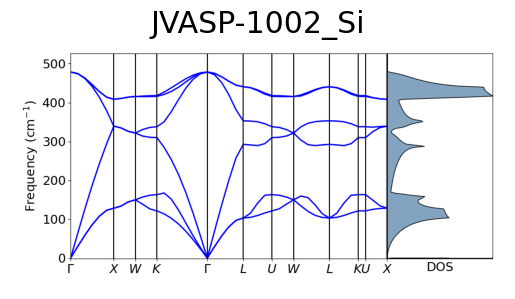

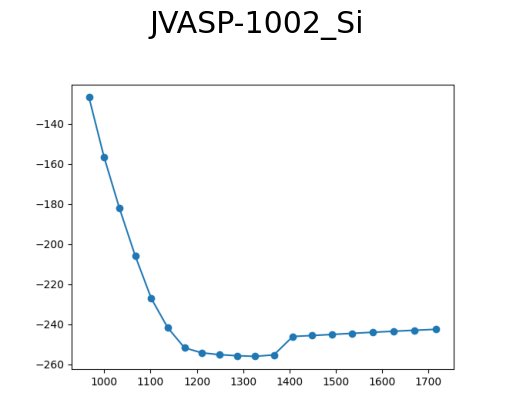

  3%|▎         | 1/36 [00:44<26:08, 44.83s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al

      Step     Time          Energy          fmax
FIRE:    0 16:12:46       -2.168504        0.000000


/tmp/ipython-input-614992193.py:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


0.2184896469116211 System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al



/usr/local/lib/python3.11/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
/content/alignn/alignn/ff/calculators.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

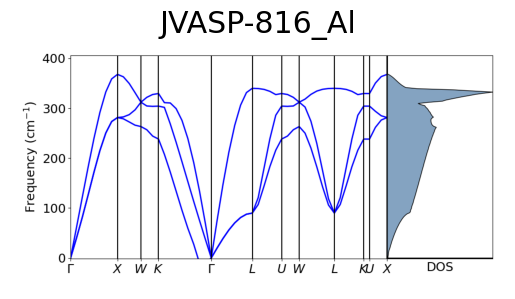

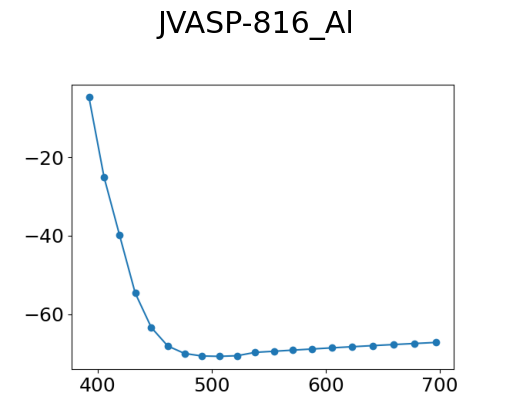

  6%|▌         | 2/36 [01:12<19:46, 34.89s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu

      Step     Time          Energy          fmax
FIRE:    0 16:13:15        0.651973        0.000000


/tmp/ipython-input-614992193.py:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


0.22710347175598145 System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu



/usr/local/lib/python3.11/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
/content/alignn/alignn/ff/calculators.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

In [ ]:
%%time
%matplotlib inline
# Note this is a different model than that published in originall
# https://doi.org/10.1039/D2DD00096B
import matplotlib.pyplot as plt
#jids=['JVASP-1002']
jids=jids_check
model_path = default_path()

calc = AlignnAtomwiseCalculator(
    path=model_path,
    stress_wt=0.05,
)
aff_lat = []
wiki_lat = []
formulas = []
for jid in tqdm(jids, total=len(jids)):
    s = Atoms.from_dict(get_jid_data(jid=jid, dataset="dft_3d")["atoms"])

    print(s)
    t1 = time.time()
    formula=s.composition.reduced_formula
    opt = general_relaxer(atoms=s, calculator=calc)
    t2 = time.time()
    aff_lat.append(opt.lattice_mat[0][0])
    formulas.append(s.composition.reduced_formula)
    print(t2 - t1, opt)  # , w cs, mean_absolute_error(iki_lat, aff_lat))
    strains = np.arange(-0.1, 0.1, 0.01)
    vols = []
    ens = []
    for i in (strains):
        sup = opt.get_conventional_atoms.make_supercell_matrix([2, 2, 2])
        atms = sup.strain_atoms(i)
        # atms=opt.strain_atoms(i)
        ase_atoms = atms.ase_converter()
        ase_atoms.calc = calc
        en = ase_atoms.get_potential_energy()
        ens.append(en)
        vols.append(atms.volume)
        # vols.append(atms.volume**(1/3))
    plt.plot(vols, ens, "-o")
    fname = "ev_" + jid +"_"+formula+ ".png"
    plt.savefig(fname)
    plt.close()
    atoms = opt.get_primitive_atoms
    name = jid +"_"+formula
    phonopy_bands_figname = "ph_" + name+ ".png"

    phonopy_bands_figname = "ph_" + jid +"_"+formula+ ".png"
    ph = phonons(
        model_path=model_path,
        atoms=atoms,
        phonopy_bands_figname=phonopy_bands_figname,
        force_multiplier=1.9,
    )
    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(phonopy_bands_figname))
    plt.show()
    plt.close()

    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(fname))
    plt.show()
    plt.close()

In [ ]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop

  Preparing metadata (setup.py) ... done


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k


/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


len generated 40


100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


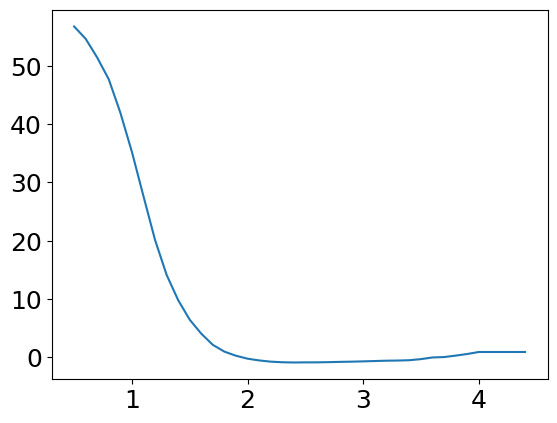

Min val -0.9049236540363553 at 2.3999999999999995


In [ ]:
from jarvis.db.jsonutils import loadjson
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
poscar_1="""SePb
1.0
3.7915451495815202 2.0179111e-09 2.189049588909996
1.2638480536514642 3.5747026449991512 2.189049588909996
0.0 0.0 4.378099177819992
Pb Se
1 1
Cartesian
0.0 0.0 0.0
2.5277 1.78735 4.3781
"""
poscar_2="""Pb
1.0
3.0698776614655223 1.6064780811e-06 1.7723974364942805
1.0232937672951337 2.894307780811061 1.7723973872638596
2.09483931e-06 1.4211877594e-06 3.544790250482119
Pb
1
Cartesian
-7.37161948995e-10 1.114499506167e-09 7.940777072720001e-10
"""
atoms1 = Poscar.from_string(poscar_1).atoms
atoms2 = Poscar.from_string(poscar_2).atoms
seperations=np.arange(0.5,4.5,0.1)
# disp_intvl = 0.1 for xy-plane scan
x = InterfaceCombi(
    film_indices=[[1, 0, 0]],
    subs_indices=[[1, 0, 0]],
    vacuum_interface=2,
    film_mats=[atoms1],
    subs_mats=[atoms2],
    disp_intvl=0.0,
    seperations=seperations,
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
    max_area=300,
    ltol=0.08,
    dataset=[None],

)
extra_params={}
extra_params["alignn_params"]={}
extra_params["alignn_params"]["model_path"]=default_path()

structs = x.generate()
wads = x.calculate_wad(method='alignn_ff',extra_params=extra_params)
plt.plot(seperations,wads)
plt.show()
print('Min val',min(wads),'at',seperations[np.argmin(wads)])

In [ ]:
from jarvis.db.jsonutils import loadjson
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
poscar_1="""SePb
1.0
3.7915451495815202 2.0179111e-09 2.189049588909996
1.2638480536514642 3.5747026449991512 2.189049588909996
0.0 0.0 4.378099177819992
Pb Se
1 1
Cartesian
0.0 0.0 0.0
2.5277 1.78735 4.3781
"""
poscar_2="""Pb
1.0
3.0698776614655223 1.6064780811e-06 1.7723974364942805
1.0232937672951337 2.894307780811061 1.7723973872638596
2.09483931e-06 1.4211877594e-06 3.544790250482119
Pb
1
Cartesian
-7.37161948995e-10 1.114499506167e-09 7.940777072720001e-10
"""
atoms1 = Poscar.from_string(poscar_1).atoms
atoms2 = Poscar.from_string(poscar_2).atoms

# disp_intvl = 0.1 for xy-plane scan
x = InterfaceCombi(
    film_indices=[[1, 0, 0]],
    subs_indices=[[1, 0, 0]],
    vacuum_interface=2,
    film_mats=[atoms1],
    subs_mats=[atoms2],
    disp_intvl=0.1,
    seperations=[seperations[np.argmin(wads)]],
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
    max_area=300,
    ltol=0.08,
    dataset=[None],

)
extra_params={}
extra_params["alignn_params"]={}
extra_params["alignn_params"]["model_path"]=default_path()

structs = x.generate()
wads = x.calculate_wad(method='alignn_ff',extra_params=extra_params)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k


/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


len generated 121


100%|██████████| 121/121 [01:22<00:00,  1.46it/s]


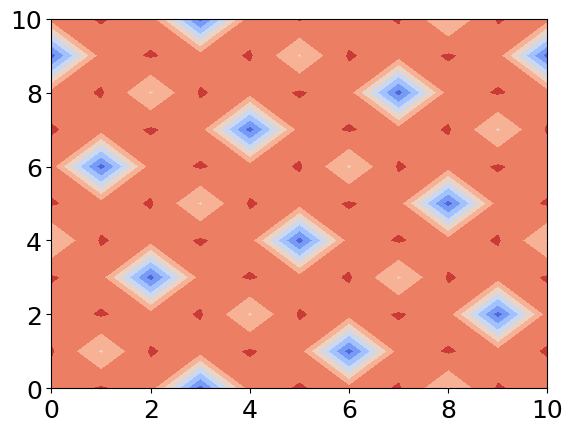

In [ ]:
from matplotlib import cm

X = x.X
Y = x.Y

wads = np.array(wads).reshape(len(X), len(Y))
plt.contourf(wads, cmap=cm.coolwarm)
